In [ ]:
pip install gym

In [ ]:
import gym
import random

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# FrozeLake Deep Q-Learning
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']     # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)

    # Train the FrozeLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0

        for i in range(episodes):
            state = env.reset() # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")

        # Create new graph
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        # Save plots
        plt.savefig('frozen_lake_dql.png')

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts an state (int) to a tensor representation.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15.

    Parameters: state=1, num_states=16
    Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state,reward,terminated,truncated = env.step(action)

        env.close()

    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features

        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s+1)%4==0:
                print() # Print a newline every 4 states



Policy (random, before training):
00,D,[-0.20 +0.12 -0.08 +0.09] 01,R,[-0.23 +0.13 +0.18 +0.06] 02,D,[-0.15 +0.09 +0.07 +0.05] 03,D,[-0.19 +0.09 +0.02 +0.08] 
04,R,[-0.10 +0.04 +0.08 -0.07] 05,R,[-0.21 +0.10 +0.18 +0.10] 06,R,[-0.12 +0.08 +0.11 +0.01] 07,D,[-0.17 +0.10 +0.00 +0.02] 
08,R,[-0.21 +0.08 +0.14 +0.05] 09,D,[-0.07 +0.08 +0.04 -0.04] 10,D,[-0.07 +0.11 +0.04 -0.00] 11,D,[-0.19 +0.14 +0.07 +0.03] 
12,D,[-0.21 +0.07 -0.04 +0.02] 13,U,[-0.30 +0.04 +0.09 +0.20] 14,U,[-0.20 -0.01 +0.04 +0.05] 15,R,[-0.23 +0.05 +0.12 +0.08] 
Policy (trained):
00,D,[-0.20 +0.12 -0.08 +0.09] 01,R,[-0.23 +0.13 +0.18 +0.06] 02,D,[-0.15 +0.09 +0.07 +0.05] 03,D,[-0.19 +0.09 +0.02 +0.08] 
04,R,[-0.10 +0.04 +0.08 -0.07] 05,R,[-0.21 +0.10 +0.18 +0.10] 06,R,[-0.12 +0.08 +0.11 +0.01] 07,D,[-0.17 +0.10 +0.00 +0.02] 
08,R,[-0.21 +0.08 +0.14 +0.05] 09,D,[-0.07 +0.08 +0.04 -0.04] 10,D,[-0.07 +0.11 +0.04 -0.00] 11,D,[-0.19 +0.14 +0.07 +0.03] 
12,D,[-0.21 +0.07 -0.04 +0.02] 13,U,[-0.30 +0.04 +0.09 +0.20] 14,U,[-0.20

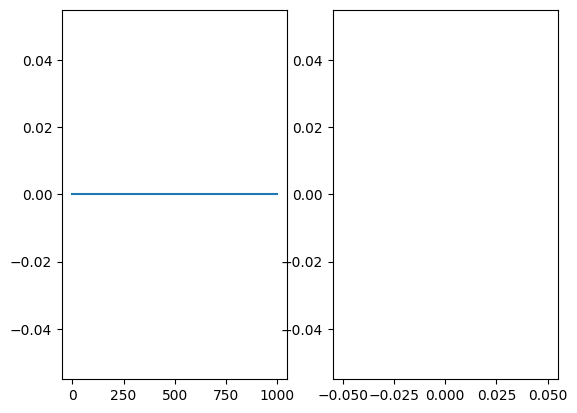

In [ ]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = False
    frozen_lake.train(1000, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)

Policy (random, before training):
0: L=0.014, D=0.032, R=0.035, U=0.071
1: L=0.050, D=0.092, R=0.117, U=-0.013
2: L=0.088, D=-0.007, R=0.090, U=0.015
3: L=0.109, D=0.084, R=0.089, U=0.070
4: L=0.041, D=0.080, R=0.068, U=0.024
5: L=0.023, D=0.087, R=0.049, U=0.022
6: L=0.051, D=-0.012, R=0.109, U=0.007
7: L=0.052, D=0.123, R=0.105, U=0.037
8: L=0.067, D=0.004, R=0.027, U=0.062
9: L=-0.005, D=0.040, R=0.042, U=0.033
10: L=0.051, D=0.063, R=0.055, U=-0.002
11: L=0.026, D=0.079, R=0.132, U=0.023
12: L=0.054, D=0.008, R=0.020, U=0.091
13: L=-0.013, D=0.076, R=0.030, U=0.060
14: L=0.018, D=0.001, R=0.098, U=0.018
15: L=0.092, D=0.034, R=0.131, U=-0.010
Policy (learned, after training):
0: L=0.014, D=0.032, R=0.035, U=0.071
1: L=0.050, D=0.092, R=0.117, U=-0.013
2: L=0.088, D=-0.007, R=0.090, U=0.015
3: L=0.109, D=0.084, R=0.089, U=0.070
4: L=0.041, D=0.080, R=0.068, U=0.024
5: L=0.023, D=0.087, R=0.049, U=0.022
6: L=0.051, D=-0.012, R=0.109, U=0.007
7: L=0.052, D=0.123, R=0.105, U=0.037
8: L

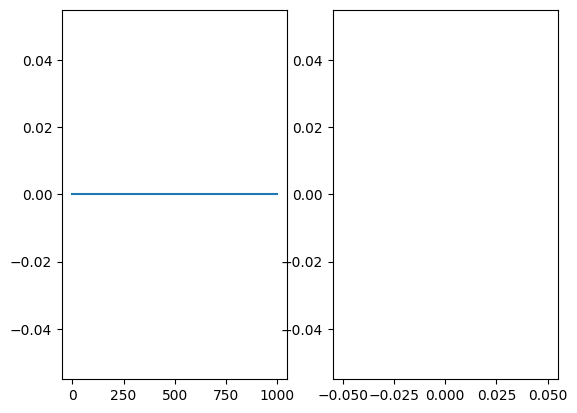

In [ ]:
import  gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # output layer

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# FrozenLake Deep Q-Learning
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.0005         # learning rate (alpha)
    discount_factor_g = 0.99         # discount rate (gamma)
    network_sync_rate = 5            # number of steps before syncing the policy and target network
    replay_memory_size = 5000        # size of replay memory
    mini_batch_size = 64             # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()           # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                 # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']      # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)

    # Train the FrozenLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1  # Initial epsilon value for exploration
        epsilon_decay = 0.995  # Epsilon decay rate
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=64, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=64, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0

        for i in range(episodes):
            state = env.reset()  # Initialize to state 0
            terminated = False   # True when agent falls in hole or reached goal
            truncated = False    # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole/reaches the goal (terminated), or has taken 200 actions (truncated).
            while not terminated and not truncated:

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample()  # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                new_state, reward, terminated, truncated = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count += 1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon * epsilon_decay, 0.01)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")

        # Create new graph
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121)  # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122)  # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        # Save plots
        plt.savefig('frozen_lake_dql.png')

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent either reached the goal (reward=1) or fell into a hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (int) to a tensor representation.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15.

    Parameters: state=1, num_states=16
    Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, num_states:int) -> torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Run the FrozenLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=64, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()  # Switch model to evaluation mode

        print('Policy (learned, after training):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()  # Initialize to state 0
            terminated = False
            truncated = False
            print(f"\nEPISODE {i+1}\n--------")

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while not terminated and not truncated:

                # Select best action
                action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                new_state, reward, terminated, truncated = env.step(action)

                # Move to the next state
                state = new_state

                print(f"Action: {self.ACTIONS[action]} | Reward: {reward}")

        # Close environment
        env.close()

    # Print the Q-values from the DQN for each state in the FrozenLake map.
    def print_dqn(self, dqn):
        num_states = dqn.fc1.in_features

        for state in range(num_states):
            q_values = dqn(self.state_to_dqn_input(state, num_states))
            print(f'{state}: L={q_values[0]:.3f}, D={q_values[1]:.3f}, R={q_values[2]:.3f}, U={q_values[3]:.3f}')

# Test model
dql = FrozenLakeDQL()
dql.train(episodes=1000)
dql.test(episodes=5)
